# Imports Libraries 


In [33]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
import numpy as np



# Scraping Daft

In [ ]:
# Set number of pages to scrape
num_pages = 600

# Create an empty list to store the data
data = []

# Initialize the WebDriver 
driver = webdriver.Chrome("Users/cdunne/Desktop/chromedriver_mac64/chromedriver")

# Navigate to the website and accept cookies
driver.get("https://www.daft.ie/")
accept_cookies_button = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//button[@data-tracking="cc-accept"]')))
accept_cookies_button.click()

# Create an iterator for page numbers
page_iterator = itertools.count(start=1, step=1)

# Loop through pages and extract listings
for page in itertools.islice(page_iterator, num_pages):
    # Navigate to the page
    url = f"https://www.daft.ie/property-for-sale/ireland?pageSize=20&from={(page-1)*20}"
    driver.get(url)

    # Wait for the listings to load
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//div[@data-testid="card-body"]'))
    )

    # Scroll down the page to load all listings
    body = driver.find_element(By.TAG_NAME, "body")
    for _ in range(20):
        body.send_keys(Keys.PAGE_DOWN)

    # Extract property listings
    listings = driver.find_elements(By.XPATH, '//div[@data-testid="card-body"]')

    # Create an iterator for listing indices
    listing_iterator = enumerate(listings)

    # Loop through listings and extract details
    for idx, listing in listing_iterator:
        # Extract details
        price = listing.find_element(By.XPATH, './/div[contains(@class, "TitleBlock__Price")]').text.strip()
        address = listing.find_element(By.XPATH, './/h2[contains(@class, "TitleBlock__Address")]').text.strip()
        # Get the number of bedrooms, bathrooms, and floor area
        try:
            beds_str = listing.find_element(By.XPATH, './/p[@data-testid="beds"]').text
            beds = int(beds_str.split()[0]) if beds_str else None
        except:
            beds = None
        try:
            baths_str = listing.find_element(By.XPATH, './/p[@data-testid="baths"]').text
            baths = int(baths_str.split()[0]) if baths_str else None
        except:
            baths = None
        try:
            area_str = listing.find_element(By.XPATH, './/p[@data-testid="floor-area"]').text
            area = float(area_str.replace(' m²', '')) if area_str else None
        except:
            area = None

        # Add the data to the list
        data.append([price, address, beds, baths, area])

    time.sleep(5)  # add delay to allow page to load

# Close the WebDriver
driver.quit()

# Create a pandas DataFrame from the data
df = pd.DataFrame(data, columns=['Price', 'Address', 'Beds', 'Baths', 'Area'])

# Remove duplicates
df.drop_duplicates(inplace=True)

# Save the DataFrame to a CSV file
df.to_csv('property_data.csv', index=False)

# Print the DataFrame
print(df)

# Scraping MyHome.ie

In [ ]:
# Set number of pages to scrape
num_pages = 300

# Create an empty list to store the data
data = []

# Initialize the WebDriver 
driver = webdriver.Chrome("Users/cdunne/Desktop/chromedriver_mac64/chromedriver")

# Navigate to the website
driver.get("https://www.myhome.ie/residential/ireland/property-for-sale")

# Wait for the cookie banner to load and then click on "I ACCEPT"
WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler"))).click()

# Initialize a counter for listings
count = 0

# Loop through pages and extract listings
for page in range(num_pages):
    # Navigate to the page
    url = f"https://www.myhome.ie/residential/ireland/property-for-sale?page={page+1}"
    driver.get(url)

    # Wait for the listings to load
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//a[@class="col-9"]'))
        )
    except:
        print(f"Failed to load listings on page {page + 1}")
        time.sleep(random.uniform(5, 10))
        continue

    # Scroll down the page to load all listings
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(random.uniform(3, 6))

    # Extract property listings
    listings = driver.find_elements(By.XPATH, '//a[@class="col-9"]')

    # Loop through listings and extract details
    for listing in listings:
        # Extract details
        price = listing.find_element(By.XPATH, './/h2').text.strip()
        address = listing.find_element(By.XPATH, './/h3').text.strip()
        
        # Get the number of bedrooms and floor area
        try:
            info_str = listing.find_element(By.XPATH, './/div[@class="property-card__info-strip info-text text-truncate my-2"]').text
            info_list = info_str.split('•')

            # Extract beds
            beds = info_list[0].strip() if info_list else None
            beds = int(beds.split()[0]) if beds and 'bed' in beds else None

            # Extract area
            area = info_list[1].strip() if len(info_list) > 1 else None
            area = float(area.replace('m 2', '')) if area and 'm 2' in area else None
        except:
            beds = None
            area = None

        # Add the data to the list
        data.append([price, address, beds, area])
        count += 1

        # If we've processed 10 listings, write to CSV
        if count % 10 == 0:
            df = pd.DataFrame(data, columns=['Price', 'Address', 'Beds', 'Area'])
            df.to_csv('myhome_property_data_V2.csv', mode='a', index=False, header=False)

    time.sleep(random.uniform(5, 10))  # add delay to allow page to load

# Write any remaining data to CSV
if data:
    df = pd.DataFrame(data, columns=['Price', 'Address', 'Beds', 'Area'])
    df.to_csv('myhome_property_data.csv', mode='a', index=False, header=False)

# Close the WebDriver
driver.quit()

print(df)


# Bringing Daft.ie + Myhome in to one dataframe

In [ ]:
#cleaned + put myhome and daft together 
df= pd.read_csv('property_data.csv')
# Remove the '€' sign and ',' from the 'Price' column
df['Price'] = df['Price'].replace('[\€,]', '', regex=True)
#nan_count = df['Price'].isna().sum()
#print("Number of NaN values in 'Price' column:", nan_count)
df = df.dropna(subset=['Price'])

# Convert the 'Price' column to numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
# Drop the 'Baths' and 'Area' columns
df = df.drop(['Baths', 'Area'], axis=1)
#alot of the beds with no value are sites or have no price will drop for analysis
df = df.dropna(subset=['Beds'])


# Extract county from 'Address' column
df['County'] = df['Address'].str.extract(', (Co\. \w+)', expand=True)
df['County'] = df['County'].str.replace('Co\. ', '')
df = df.dropna(subset=['County'])
print(df)



df2 = pd.read_csv('myhome_property_data.csv')

# Drop the 'Area' column
df2 = df2.drop('Area', axis=1)

# Remove the Euro sign and non-numeric values from the 'Price' column
df2['Price'] = df2['Price'].str.replace('[^\d.]', '', regex=True)
df2['Price'] = pd.to_numeric(df2['Price'], errors='coerce')
df2 = df2.dropna(subset=['Price'])
# Extract county from 'Address' column
df2['County'] = df2['Address'].str.extract(', (\w+)$', expand=False)
#neeeded to add this in as there was twons in county column
df2 = df2.dropna(subset=['County'])
valid_counties = df['County'].unique()
df2 = df2[df2['County'].isin(valid_counties)]


# Print the updated dataframe
print(df2)
print(df2['County'].unique())


# Combine the two datasets into a single dataframe
combined_df = pd.concat([df, df2], ignore_index=True)
combined_df['Year'] =2023
# Print the combined dataframe
print(combined_df)

# Api Call to CSO for average wage by gender and county

In [ ]:
# Fetch JSON data from the URLs
url_2 = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/NEA06/JSON-stat/2.0/en"

response_2 = requests.get(url_2)

# Load the JSON data into a Python dictionary
data_2 = json.loads(response_2.text)

# Extract the dimensions and value data
dimensions_2 = data_2['dimension']
obs_values_2 = data_2['value']

# Extract the index labels from dimensions
index_labels_2 = [dimensions_2[key]['label'] for key in dimensions_2.keys() if key != 'id']

# Extract the categories from dimensions
categories_2 = [dimensions_2[key]['category']['index'] for key in dimensions_2.keys() if key != 'id']

# Generate the DataFrame indices
multi_index_2 = pd.MultiIndex.from_product(categories_2, names=index_labels_2)

# Create the DataFrames with the multi-indices and the observed values
df_2 = pd.DataFrame(obs_values_2, index=multi_index_2, columns=['Value'])

# Reset the indices to turn the multi-indices into columns
df_2.reset_index(inplace=True)

# Define the mapping
county_mapping = {
    '01': 'Carlow',
    '02': 'Dublin',
    '03': 'Kildare',
    '04': 'Kilkenny',
    '05': 'Laois',
    '06': 'Longford',
    '07': 'Louth',
    '08': 'Meath',
    '09': 'Offaly',
    '10': 'Westmeath',
    '11': 'Wexford',
    '12': 'Wicklow',
    '13': 'Clare',
    '14': 'Cork',
    '15': 'Kerry',
    '16': 'Limerick',
    '17': 'Tipperary',
    '18': 'Waterford',
    '19': 'Galway',
    '20': 'Leitrim',
    '21': 'Mayo',
    '22': 'Roscommon',
    '23': 'Sligo',
    '24': 'Cavan',
    '25': 'Donegal',
    '26': 'Monaghan'
}
gender_mapping = {
    '1': 'Male',
    '2': 'Female'
}

# Map the county codes to names
df_2['County'] = df_2['County'].map(county_mapping)
df_2['Sex'] = df_2['Sex'].map(gender_mapping)
#get rid of aggregated data
df_2.dropna(inplace=True)

#bad naming convetion left confusing
cso_data = df_2
# Print the result DataFrame
print(cso_data)

# Drop the 'Statistic' column
cso_data = cso_data.drop('Statistic', axis=1)

# Rename the 'Value' column to 'Mean Wage'
cso_data = cso_data.rename(columns={'Value': 'Mean Wage'})
# Calculating average wages across genders
cso_data['Average Wage'] = cso_data.groupby(['Year', 'County'])['Mean Wage'].transform('mean')
print(cso_data)

# CSO Data for historical house prices

In [ ]:
hd = pd.read_csv('csoMeanhouseprices.csv')
# Rename 'VALUE' column to 'Price'
hd = hd.rename(columns={'VALUE': 'Price'})
# Now, the same operations as before, but with 'Price' instead of 'VALUE'
hd_filtered = hd[(hd['Type of Buyer'] == 'All Buyer Types') & (hd['Type of Sale'] == 'All Sale Types')]
# Convert 'Month' to datetime and sort by it
hd_filtered['Month'] = pd.to_datetime(hd_filtered['Month'])
hd_filtered = hd_filtered.sort_values(by='Month')
# Group by 'County' and 'Month', then compute the mean of 'Price'
mean_prices = hd_filtered.groupby(['County', 'Month'])['Price'].mean().reset_index()
mean_prices['Year'] = mean_prices['Month'].dt.year
#Calculate the average price per year per county
mean_prices['Yearly Average Price'] = mean_prices.groupby(['Year', 'County'])['Price'].transform('mean')

print(mean_prices)

# Data Preprocessing, Analysis, and Modeling

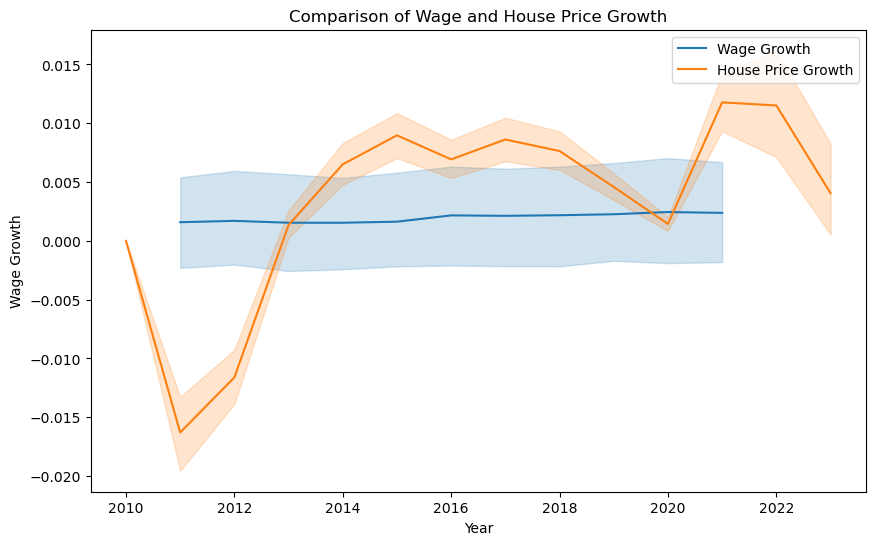

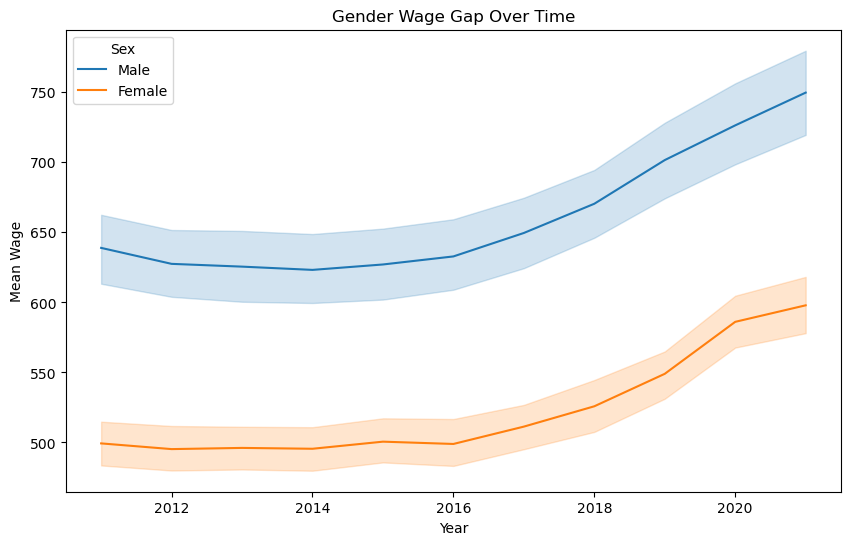

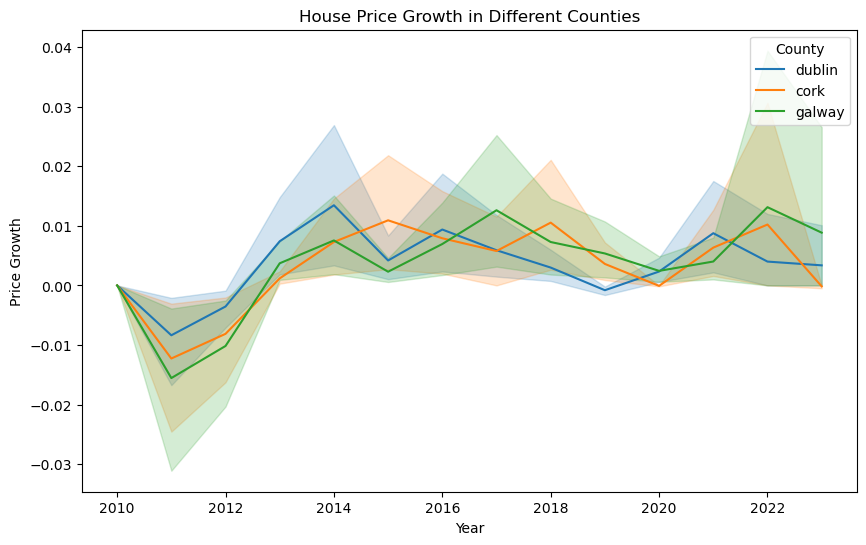

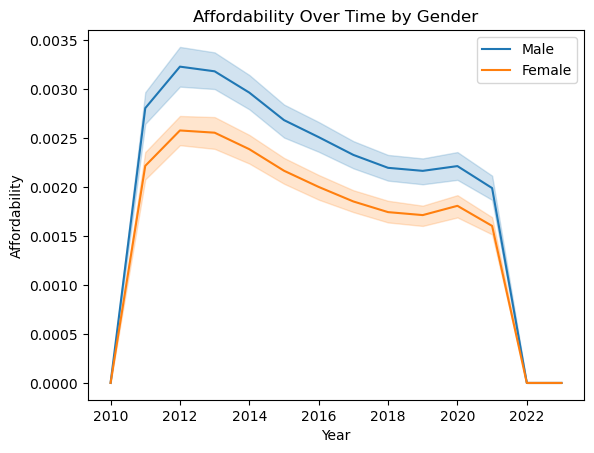

Year                       0
Mean Wage               1020
Average Wage            1020
Wage Growth             1152
Yearly Average Price     186
Price Growth              57
Affordability_Male         0
Affordability_Female       0
County_all counties        0
County_antrim              0
County_armagh              0
County_carlow              0
County_cavan               0
County_clare               0
County_cork                0
County_donegal             0
County_down                0
County_dublin              0
County_fermanagh           0
County_galway              0
County_kerry               0
County_kildare             0
County_kilkenny            0
County_laois               0
County_leitrim             0
County_limerick            0
County_longford            0
County_louth               0
County_mayo                0
County_meath               0
County_monaghan            0
County_offaly              0
County_roscommon           0
County_sligo               0
County_tippera

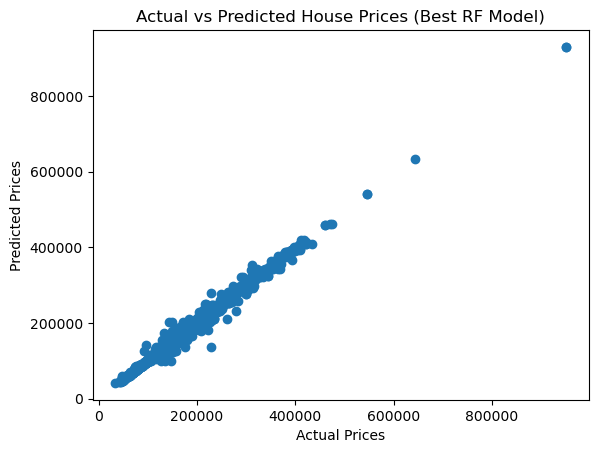

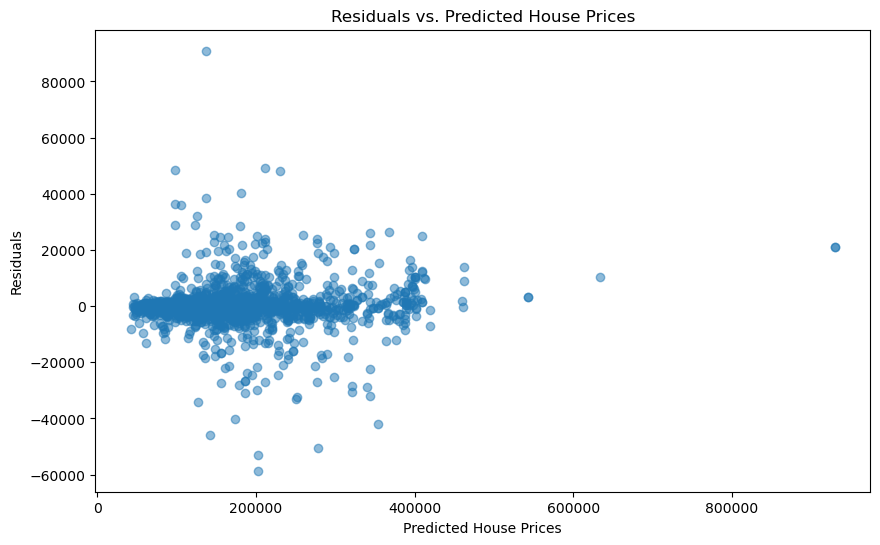

In [43]:

def preprocess_data(dataframe):
    dataframe['Year'] = dataframe['Year'].astype(int)
    dataframe['County'] = dataframe['County'].str.lower()
    return dataframe

# Preprocess dataframes
cso_data = preprocess_data(cso_data)
mean_prices = preprocess_data(mean_prices)
combined_df = preprocess_data(combined_df)

# Filter combined_df for the year 2023
combined_df_2023 = combined_df[combined_df['Year'] == 2023]

# Calculate the average price per county for 2023
average_price_2023 = combined_df_2023.groupby('County')['Price'].mean().reset_index()

# Create a new column 'Year' in average_price_2023 and set it to 2023
average_price_2023['Year'] = 2023
# Append this data to the 'mean_prices' dataframe
mean_prices = pd.concat([mean_prices, average_price_2023], ignore_index=True)

# Calculate yearly growth rates
cso_data['Wage Growth'] = cso_data.groupby('Year')['Average Wage'].pct_change()

# Calculate price growth for each county
mean_prices.sort_values(by=['County', 'Year'], inplace=True)
mean_prices['Price Growth'] = mean_prices.groupby('County')['Yearly Average Price'].pct_change()

# Merge the datasets
merged_data = pd.merge(cso_data, mean_prices, on=['Year', 'County'], how='outer')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Wage Growth', data=merged_data, label='Wage Growth')
sns.lineplot(x='Year', y='Price Growth', data=merged_data, label='House Price Growth')
plt.title('Comparison of Wage and House Price Growth')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Mean Wage', hue='Sex', data=cso_data)
plt.title('Gender Wage Gap Over Time')
plt.show()

selected_counties = ['dublin', 'cork', 'galway']  # Select a few representative counties
filtered_data = merged_data[merged_data['County'].isin(selected_counties)]

plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Price Growth', hue='County', data=filtered_data)
plt.title('House Price Growth in Different Counties')
plt.show()

# Calculate affordability for each gender
merged_data['Affordability_Male'] = merged_data[merged_data['Sex'] == 'Male']['Mean Wage'] / merged_data['Price']
merged_data['Affordability_Female'] = merged_data[merged_data['Sex'] == 'Female']['Mean Wage'] / merged_data['Price']

# Fill NaN values with 0
merged_data['Affordability_Male'] = merged_data['Affordability_Male'].fillna(0)
merged_data['Affordability_Female'] = merged_data['Affordability_Female'].fillna(0)

# Plot affordability
sns.lineplot(x='Year', y='Affordability_Male', data=merged_data, label='Male')
sns.lineplot(x='Year', y='Affordability_Female', data=merged_data, label='Female')
plt.title('Affordability Over Time by Gender')
plt.xlabel('Year')
plt.ylabel('Affordability')
plt.legend()
plt.show()

# One-hot encoding for the 'County' variable
merged_data_encoded = pd.get_dummies(merged_data, columns=['County','Sex'])

# Split the data into training and testing sets
X = merged_data_encoded.drop(columns=['Price'])
y = merged_data_encoded['Price']

# Check for NaN values in the dataframe
print(X.isna().sum())

# Replace NaN values with the mean of the column
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Check for infinite values in the dataframe (replace 'inf' with a high value)
X = X.replace([np.inf, -np.inf], np.finfo(np.float32).max)
y = y.replace([np.inf, -np.inf], np.finfo(np.float32).max)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Making sure y is a 1D array for the model
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Create and train a Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Perform cross-validation
cv_rf_reg = cross_val_score(estimator=rf_reg, X=X_train, y=y_train, cv=10)
print(f"Cross-validation score: {np.mean(cv_rf_reg)}")

# Make predictions
y_pred_rf = rf_reg.predict(X_test)

# Print errors
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50]
}

# Perform Grid Search CV
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Create a new random forest regressor with the best parameters
best_rf_reg = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'], 
                                    max_depth=grid_search.best_params_['max_depth'], 
                                    random_state=42)

# Fit the model and make predictions
best_rf_reg.fit(X_train, y_train)
y_pred_best_rf = best_rf_reg.predict(X_test)

# Print errors for the best model
print('Mean Absolute Error (best):', metrics.mean_absolute_error(y_test, y_pred_best_rf))
print('Mean Squared Error (best):', metrics.mean_squared_error(y_test, y_pred_best_rf))
print('Root Mean Squared Error (best):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_best_rf)))

# Visualizing the predictions of the best model
plt.scatter(y_test, y_pred_best_rf)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices (Best RF Model)')
plt.show()

# Predicting with the best estimator
best_rf_reg = grid_search.best_estimator_
y_pred_best = best_rf_reg.predict(X_test)

# Plotting residuals
residuals = y_test - y_pred_best

plt.figure(figsize=(10,6))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted House Prices')
plt.xlabel('Predicted House Prices')
plt.ylabel('Residuals')
plt.show()
